In [3]:
import sys

sys.path.insert(0, '../')

import specutils
specutils

<module 'specutils' from '../specutils/__init__.py'>

In [4]:
from astropy.table import Table
from astropy.utils import data
from astropy.io import fits
from astropy import units as u
from astropy import constants as cnst
import numpy as np

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

# Downloads/prep

## SDSS Spectra

First lets grab a few example spectra from the SDSS.  These are fairly typical lowish resolution stellar spectra. We start by getting a convenient list of known nearish K/M-type stars.

In [6]:
sdss_qry = """
SELECT z, ra, dec, sourceType, targetType, secTarget, fiberID, plate, mjd, specObjID, bestObjID, fluxObjID, targetObjID, plateID, sn1_r, sn2_r, spectroFlux_r, subClass 
FROM specObj 
WHERE ancillary_target1 & dbo.fAncillaryTarget1('RED_KG') > 0 
"""

t = Table.read('red_kgs_eteq.csv')
t['avg_sn'] = (t['sn1_r'] + t['sn2_r'])/2
t.sort('avg_sn')
t.reverse()
t['spectype'] = [sc.split('(')[0].strip() for sc in t['subClass']]
t['lumclass'] = [''.join([char for char in st[2:] if char.isupper()]) for st in t['spectype']]
giants = t['lumclass'] == 'III'
np.sum(giants)

334

Now download a couple of giants chosen to span the S/N range of this sample.

In [7]:
templ_spec_path = 'https://dr16.sdss.org/optical/spectrum/view/data/format=fits/spec=lite?plateid={plate}&mjd={mjd}&fiberid={fiberID}'

../specutils/io/default_loaders/sdss.py:80: RuntimeWarning: divide by zero encountered in true_divide
  stdev = np.sqrt(1.0/hdulist[1].data['ivar'])


('K4III', <Quantity 87.08272388 km / s>)

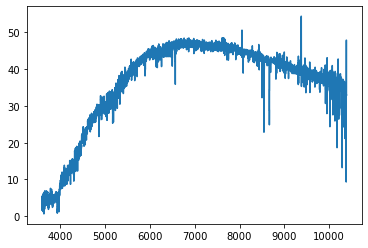

In [8]:
row = t[giants][0]
url = templ_spec_path.format(**{nm: row[nm] for nm in 'plate,mjd,fiberID'.split(',')})
fn = data.download_file(url, timeout=30)
brightspec = specutils.Spectrum1D.read(fn, format='SDSS-III/IV spec')

plt.step(brightspec.wavelength, brightspec.flux)
brightspec.radial_velocity = row['z']*cnst.c.to(u.km/u.s)
row['spectype'], brightspec.radial_velocity

In [9]:
row = t[giants][-2]
url = templ_spec_path.format(**{nm: row[nm] for nm in 'plate,mjd,fiberID'.split(',')})
fn = data.download_file(url, timeout=30)
faintspec = specutils.Spectrum1D.read(fn, format='SDSS-III/IV spec')

faintspec.radial_velocity = row['z']*cnst.c.to(u.km/u.s)
row['spectype'], faintspec.radial_velocity

('K2III', <Quantity -52.92302215 km / s>)

##  Template spectra

Use the Phoenix grids as the templates.  For example purposes we will just grab two, one that's about the right teff/logg for a K2III, and another more like a K4III:

In [10]:
# note these are very slow downloads, so just recording urls here and downloaded separately
templ_logg2p5_teff5200_url = 'http://osubdd.ens-lyon.fr/phoenix/phoenix.cgi?c=i&a=mime:application/fits&o=phoenix:Grids/BT-Settl/CIFIST2011_2015/SPECTRA/lte052.0-2.5-0.0a+0.0.BT-Settl.spec.7.xz'
templ_logg2p5_teff4600_url = 'http://osubdd.ens-lyon.fr/phoenix/phoenix.cgi?c=i&a=mime:application/fits&o=phoenix:Grids/BT-Settl/CIFIST2011_2015/SPECTRA/lte046.0-2.5-0.0a+0.0.BT-Settl.spec.7.xz'

In [11]:
f46 = fits.open('phoenix_Grids_BT-Settl_CIFIST2011_2015_SPECTRA_lte046.0-2.5-0.0a 0.0.BT-Settl.spec.7.xz.fits')
templ_spec4600 = specutils.Spectrum1D(spectral_axis=f46[1].data['WAVELENGTH']*u.angstrom, 
                                      flux=f46[1].data['FLUX']*u.angstrom)

In [12]:
f52 = fits.open('phoenix_Grids_BT-Settl_CIFIST2011_2015_SPECTRA_lte052.0-2.5-0.0a 0.0.BT-Settl.spec.7.xz.fits')
templ_spec5200 = specutils.Spectrum1D(spectral_axis=f52[1].data['WAVELENGTH']*u.angstrom, 
                                      flux=f52[1].data['FLUX']*u.angstrom)

(8000, 9000)

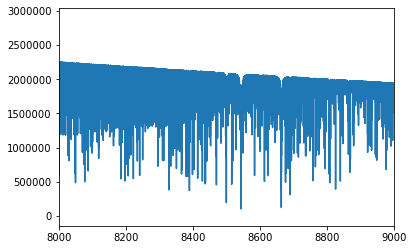

In [13]:
plt.step(templ_spec4600.wavelength, templ_spec4600.flux)
plt.xlim(8000, 9000)

Very different resolution... but lets see what happens:

In [30]:
from specutils.analysis.correlation import template_correlate # this should be from analysis not correlation

In [31]:
template_correlate(brightspec, templ_spec5200)

ValueError: operands could not be broadcast together with shapes (4608,) (1336340,) 

Hmmm.  Does not auto re-sample just as the docs say. Need to resample, but should smooth the template *first* to something slightly higher-res than the observed spectra.

First lets figure out how much to smooth the template to match the data

In [21]:
from specutils import analysis, manipulation

In [22]:
#overlap_region = specutils.SpectralRegion(brightspec.spectral_axis.min(), brightspec.spectral_axis.max())
#res = manipulation.extract_region(templ_spec5200, overlap_region)  # <--- this is slow and shouldn't be!

In [23]:
overlap_msk = (brightspec.spectral_axis.min() < templ_spec5200.spectral_axis) & (templ_spec5200.spectral_axis < brightspec.spectral_axis.max())
templ_scale = np.median(np.diff(templ_spec5200.spectral_axis[overlap_msk]))/u.pixel
np.unique(np.diff(templ_spec5200.spectral_axis[overlap_msk])), templ_scale

(<Quantity [0.02, 0.02, 0.02, 0.02] Angstrom>, <Quantity 0.02 Angstrom / pix>)

Nearly-uniform spacing over the whole templare region of interest.  So we can use that to compute the pixel-box needed. What about the data?

<Quantity 1.40722656 Angstrom>

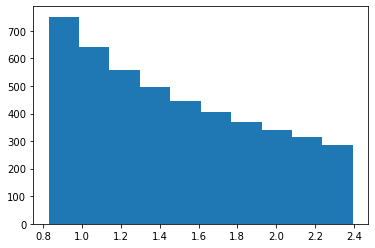

In [24]:
dlamb = np.diff(brightspec.spectral_axis)
plt.hist(dlamb.value)
np.median(dlamb)

Aha it's already a log-spaced axis. Smooth to just the median dlamb then:

(8000, 9000)

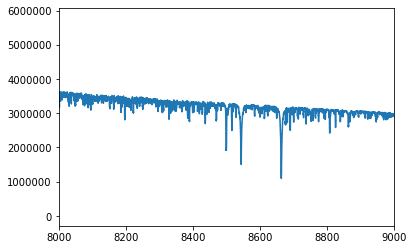

In [25]:
box_size = (np.median(dlamb)/templ_scale).value
smoothed_templ = manipulation.box_smooth(templ_spec5200, box_size)
plt.step(smoothed_templ.wavelength, smoothed_templ.flux)
plt.xlim(8000, 9000)

(8000, 9000)

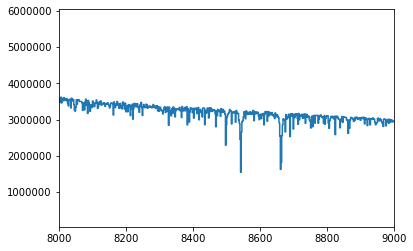

In [26]:
smoothed_resampled_templ = manipulation.LinearInterpolatedResampler()(smoothed_templ, brightspec.spectral_axis)
plt.step(smoothed_resampled_templ.wavelength, smoothed_resampled_templ.flux)
plt.xlim(8000, 9000)

Now we can cross-correlate:

../specutils/manipulation/resample.py:226: RuntimeWarning: invalid value encountered in multiply
  out_variance = np.sum(pixel_uncer * resample_grid**2, axis=-1) / np.sum(


<Quantity 37269.44085546 km / s>

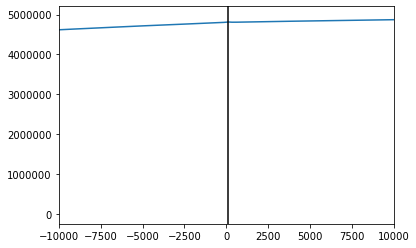

In [32]:
corr, lags = template_correlate(brightspec, smoothed_resampled_templ)
plt.plot(lags, corr)
plt.axvline(brightspec.radial_velocity.value,c = 'k')
plt.xlim(-10000, 10000)
lags[np.argmax(corr)]

Uh oh... the lags are not sampled nearly finely enough, probably because it's only once per pixel. So maybe try switching to a much higher-resolution re-binning?

Also the docs do not see resampling is happening internally.  That's a problem...

In [48]:
resampler = manipulation.LinearInterpolatedResampler('zero_fill')

new_spectral_axis = np.geomspace(np.min(brightspec.spectral_axis), 
                                 np.max(brightspec.spectral_axis), 
                                 brightspec.spectral_axis.shape[0]*2)

brightspec_resampled = resampler(brightspec, new_spectral_axis)

smoothed_templ = manipulation.box_smooth(templ_spec5200, box_size)
smoothed_resampled_templ = resampler(smoothed_templ, new_spectral_axis)

/Users/erik/miniconda3/envs/astro38/lib/python3.8/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/erik/miniconda3/envs/astro38/lib/python3.8/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
../specutils/manipulation/resample.py:226: RuntimeWarning: invalid value encountered in multiply
  out_variance = np.sum(pixel_uncer * resample_grid**2, axis=-1) / np.sum(


<Quantity -195998.84342493 km / s>

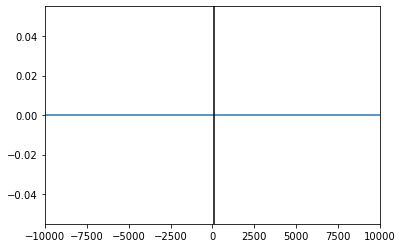

In [50]:
corr, lags = template_correlate(brightspec_resampled, smoothed_resampled_templ)
plt.plot(lags, corr)
plt.axvline(brightspec.radial_velocity.value,c = 'k')
plt.xlim(-10000, 10000)
lags[np.argmax(corr)]

Why doesn't that work??

Still missing from this workflow: 

* continuum normalization
* limited set of lags